# Simple Discourse: A Python Library for Clearer Discourse Modeling
*A CS1699 Final Project By Sean Steinle, Brandon Kowalecki, and Nolan Weinlader*
<br>

### Table of Contents
1. [The Simple Discourse Library](#a)
  1. [Source Code](#a1)
  2. [Examining the Discourse Unit and Surveying PDTB3](#a2)

<a name='a'></a>

## The Simple Discourse Library

In this notebook, we'll demo the Python library we wrote to simplify working with the Penn Discourse TreeBank version 3 (PDTB3).

<a name='a1'>

### Source Code

During the semester, we focused our time on understanding the task of discourse analysis as well as engineering the library itself, so the library is not up on PyPI yet. Because of this, I'll copy our functions into the following blocks.

In [ ]:
import os

In [ ]:
class DiscourseLoader:
    def __init__(self, path):
        self.raw_relations = self.loadCorpus(path) #each raw_relation is a two-part tuple, [0] is raw annotation, [1] is raw text

    #This method takes the path to the pdtb3 corpus and returns a tuple of the raw text of the discourse fields and the filename
    def loadCorpus(self, path):
        #This section loads the raw annotations
        relations = []
        ann_path = path+'gold/'
        for folder in os.listdir(ann_path):
            if(folder == '.DS_Store'):
                continue
            for fn in os.listdir(ann_path+folder):
                f = open(ann_path+'/'+folder+'/'+fn, 'r')
                for line in f.readlines():
                    relations.append([line,path+'raw/'+folder+'/'+fn])

        return relations


In [ ]:
class DiscourseUnit:
    def __init__(self, raw_relation):
        fields = raw_relation[0].split('|')

        #data members
        self.type_definitions_path = 'rel_type_definitions.txt'
        self.text_path = raw_relation[1]
        self.Relation = Relation(fields[0], fields[7], fields[8]) #connective=7, class=8
        self.Arg1 = Arg(fields[14], self.text_path)
        self.Arg2 = Arg(fields[20], self.text_path)

    def highlightDiscourse(self, text_file, output_file, color1='orange', color2='red', color_con='green', context_len=250): #output needs to be html
        htmlFile = '''
           <!DOCTYPE html>
        <html>
        	<head></head>
        	<body>
                <p>{0}</p>
        	</body>
        </html>
        '''
        #<p style="color:blue;">{1}</p>

        #gets text from raw text file
        text_f = open(self.text_path, 'r')
        lines = text_f.read()
        text_f.close()

        #replaces args + conn w/ html color args + conn
        lines = lines.replace('.START', '')
        repl_1 = '<font style="color:{0};">{1}</font>'.format(color1, self.Arg1.text)
        repl_2 = '<font style="color:{0};">{1}</font>'.format(color2, self.Arg2.text)
        repl_con = '<font style="color:{0};">{1}</font>'.format(color_con, self.Relation.connective)
        lines = lines.replace(self.Arg1.text, repl_1)
        lines = lines.replace(self.Arg2.text, repl_2)
        lines = lines.replace(self.Relation.connective, repl_con)

        #finds boundaries of text
        start = lines.find(repl_1)
        end = lines.find(repl_2) + len(repl_2) + len(repl_con)

        #check that boundaries are within total text window
        if(start-context_len<=0):
            start = 0
        else:
            start = start-context_len
        if(end+context_len>=len(lines)):
            end = 0
        else:
            end = end+context_len
        context = lines[start:end]

        #opens html, writes raw text
        html_f = open(output_file, 'w')
        html_f.write(self.Relation.type + ": " + self.Relation.semantic_class)
        html_f.write(self.Relation.type_definition)
        html_f.write(htmlFile.format(context))
        html_f.close()

class Arg():
    def __init__(self, raw_substring, text_path):
        self.text = self.getText(raw_substring, text_path)

    #gets the text of the argument. can be in one or multiple chunks.
    def getText(self, raw_substring, text_path):
        if(raw_substring[-1]==';'):
            raw_substring = raw_substring[:-1]
        if(';' not in raw_substring):
            nums = raw_substring.split("..")
            f = open(text_path, 'r')
            text = f.read()
            f.close()
            return text[int(nums[0]):int(nums[1])]
        else: #this case is for multi-part args...
            pairs = raw_substring.split(";")
            f = open(text_path, 'r')
            text = f.read()
            texts = ""
            for pair in pairs:
                nums = pair.split("..")
                texts+=text[int(nums[0]):int(nums[1])]+" "
            return texts

class Relation():
    def __init__(self, rel_type, connective, semantic_class):
        self.type = rel_type
        self.types_dict = self.defineTypes()
        self.type_definition = self.types_dict[rel_type]
        self.semantic_class = semantic_class
        self.connective = connective

    def defineTypes(self):
        defs = '''Explicit - Has an explicit discourse connective. Examples include since, because and therefore.
Implicit - Must be inferred, lack the cues of explicit connectives.
AltLex - Lack an explicit connective, but contain other phrasal or construction-based evidence for the relation that holds between the arguments. Cases where a discourse relation is inferred between adjacent sentences but where providing an implicit connective leads to redundancy in the expression of the relation.
AltLexC - Lack an explicit connective, but contain other phrasal or construction-based evidence for the relation that holds between the arguments. They are a type of AltLex construction, they can be found on their own, separate from other AltLex tokens but have the same fields as AltLex. Examples include so, such and too.
Hypophora - Involves a question posed in Arg1 and answer in Arg2. Explicitly marked question-response pairs.
EntRel - A relation holds between an entity mentioned in Arg1 and the contents of Arg2.
NoRel - Annotated only between adjacent sentences within a paragraph that are not linked to each other by a discourse relation.'''
        defs = defs.split('\n')
        dict = {}
        for d in defs:
            type, definition = d.split(' - ')
            dict[type] = definition
        return dict


<a name='a2'>

### Examining the Discourse Unit and Surveying Discourse Relations

In this section, let's load a few discourse units and do some basic EDA on the PDTB3.

In [ ]:
#First, we need to load the PDTB into Colab from Drive
!cp ./drive/MyDrive/Colab/pdtbMerge-v9-3.zip .
!unzip  pdtbMerge-v9-3.zip
!ls

In [ ]:
#Instantiate the DiscourseLoader object
loader = DiscourseLoader('pdtbMerge-v9-3/')

In [ ]:
#Let's make a list of five discourse units
discourse_units = []
for i in range(5):
  discourse_units.append(DiscourseUnit(loader.raw_relations[i]))

In [ ]:
#Some basic details about this discourse unit
print("Type:", discourse_units[0].Relation.type)
print("Type Definition:", discourse_units[0].Relation.type_definition)
print("Argument #1:", discourse_units[0].Arg1.text)
print("Argument #2:", discourse_units[0].Arg2.text)

Type: Explicit
Type Definition: Has an explicit discourse connective. Examples include since, because and therefore.
Argument #1: however, why limit the practice to the poor, maligned analysts whose ability to see into the future is fragile at best
Argument #2: the firms are serious


In [ ]:
#We also included a basic visualization method
discourse_units[0].highlightDiscourse(discourse_units[0].text_path, 'discourse_visualization.html')

In [ ]:
#This code loads all of the PDTB instances as DiscourseUnits
units = []
for i in range(len(loader.raw_relations)):
  print(i)
  try:
    units.append(DiscourseUnit(loader.raw_relations[i]))
  except:
    print("Colab Error")
units[:5]

In [ ]:
#Look at all those relations! Now let's make a Pandas dataframe and analyze these relations.
import pandas as pd
df = pd.DataFrame()
df['relation'] = [d.Relation.type for d in units]
df['semantic_class'] = [d.Relation.semantic_class for d in units]
df['connective'] = [d.Relation.connective for d in units]
df['arg1'] = [d.Arg1.text for d in units]
df['arg2'] = [d.Arg2.text for d in units]
df

,relation,semantic_class,connective,arg1,arg2
0,Explicit,Contingency.Condition.Arg2-as-cond,if,"however, why limit the practice to the poor, m...",the firms are serious
1,Explicit,Comparison.Concession.Arg2-as-denier,however,I'm delighted that Wall Street is finally tuni...,"why limit the practice to the poor, maligned a..."
2,Implicit,Expansion.Substitution.Arg2-as-subst,instead,"If the firms are serious, however, why limit t...",Why not extend the same harsh standards to the...
3,Explicit,Expansion.Manner.Arg2-as-manner,and,extend the same harsh standards to the sales f...,pay brokers a base salary with annual bonus ba...
4,Explicit,Expansion.Conjunction,with,and pay brokers a base salary,annual bonus based on how much money they made...
...,...,...,...,...,...
53286,Explicit,Contingency.Cause.Reason,because,The company has expressed a preference for GM ...,GM has promised it would keep Jaguar independent
53287,Explicit,Temporal.Asynchronous.Precedence,then,when it abandoned a four-year effort to market...,"last Friday, Ford's talks about a possible all..."
53288,Implicit,Contingency.Cause.Reason,since,GM's interest in Jaguar reflects a desire to h...,Its Opel line has a solid image and a recent s...
53289,Explicit,Comparison.Contrast,but,Its Opel line has a solid image and a recent s...,it lacks Jaguar's cachet


<function matplotlib.pyplot.show>

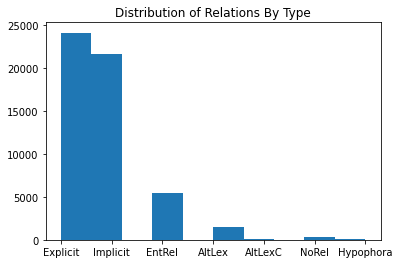

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['relation'])
plt.title("Distribution of Relations By Type")
plt.show

In [ ]:
import nltk
nltk.download('punkt')
df['arg1_count'] = df.arg1.apply(lambda x: len(nltk.word_tokenize(x)))
df['arg2_count'] = df.arg2.apply(lambda x: len(nltk.word_tokenize(x)))
arg1_count = df['arg1_count']
arg2_count = df['arg2_count']
df['arg_counts'] = arg1_count + arg2_count

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print("Average argument length (in words) for explicit relations: ", df[(df['relation']=='Explicit')]['arg_counts'].mean())
print("Average argument length (in words) for implicit relations: ", df[(df['relation']=='Implicit')]['arg_counts'].mean())

Average argument length (in words) for explicit relations:  26.49396190397145
Average argument length (in words) for implicit relations:  33.02370609981516


In [ ]:
connectives = df['connective'].value_counts(sort=True, normalize=True)
connectives = connectives[:10]
connectives

and             0.154641
                0.141731
but             0.083935
because         0.055563
also            0.040889
specifically    0.029517
while           0.028241
in order        0.024732
so              0.024319
then            0.023625
Name: connective, dtype: float64

Looks like most relations are either implicit or explicit. Of those relations, we can tell that implicit relations have arguments that are in total 6-7 words longer on average. Additionally, we see that 'and' and no connective make up almost 30% of relations.

In [ ]:
print(len(set(df['semantic_class'])))
print(df['semantic_class'].value_counts(sort=True, normalize=True))
print(df['semantic_class'].value_counts(sort=True, normalize=True)[-20:].sum())

36
Expansion.Conjunction                                       0.248072
                                                            0.111201
Comparison.Concession.Arg2-as-denier                        0.102456
Contingency.Cause.Reason                                    0.086638
Contingency.Cause.Result                                    0.075172
Expansion.Level-of-detail.Arg2-as-detail                    0.060385
Temporal.Synchronous                                        0.046837
Temporal.Asynchronous.Precedence                            0.039838
Comparison.Contrast                                         0.037417
Expansion.Instantiation.Arg2-as-instance                    0.034490
Contingency.Condition.Arg2-as-cond                          0.030699
Contingency.Purpose.Arg2-as-goal                            0.030136
Temporal.Asynchronous.Succession                            0.025483
Comparison.Concession.Arg1-as-denier                        0.014881
Expansion.Substitution.Arg2-as-

Finally, we turn to the semantic classes. This is the label that we will be predicting with our implicit sense classifier, so it is good to know the distribution of the label type in our dataset. What we find is that this category is highly imbalanced in its classes, with the most occuring class being more than double the size of the second most occuring class, and three times the size of the third most occurring class. We also find that our of 36 categories, the 20 least occuring classes make up less than 4% of all discourse units. **This is a very skewed category**.

<a name='b'></a>

## Bonus: Visualizing Discourse Model Predictions

In this section, we'll move on from simply exploring discourse data and attempt to model it!

<a name='b1'></a>

### Running a Discourse Model

The discourse model we'll be running is Chen, Chu, and Gimpel's DiscoEval implicit sense classifier (which you can find here: https://github.com/ZeweiChu/DiscoEval). Basically, this model takes two arguments are input, and attempts to predicted the semantic discourse class. In this section, we're going to run this model on the default PDTB2 dataset.

*Note on Execution*: Because we'd like to run this model with GPU's, this notebook is being run on Google Colab. Since we're running a fairly complex codebase on Colab, I'll zip the files and upload them into this runtime. This method has its drawbacks, in that you may not be able to see every change I make to the model, but we'll deal with that by flashing important code bits and describing important changes in the next section when we run the model on PDTB3.

In [ ]:
#First, we need to load the DiscoEval model into Colab from Drive
!cp ./drive/MyDrive/Colab/DiscoEval-master.zip .
!unzip  DiscoEval-master.zip
!ls

In [ ]:
!cp ./drive/MyDrive/Colab/SentEval-master.zip .
!unzip  SentEval-master.zip
!ls

In [ ]:
#Install dependencies
!pip install transformers tensorboardX

In [ ]:
#This command will run the model on PDTB2
#Note: you need to enable GPU for this
#print("config")
#!cd DiscoEval-master/train/ && python config.py --train_path DiscoEval-master/train/ --test_path DiscoEval-master/discoeval/#gonna need flags here
#print("run")
#!cd DiscoEval-master/train/ && python run.py
print("shell")
!cd DiscoEval-master/examples/ && sh run_bert.sh 4 avg base

shell
6a86286559a6
task: 4
layer: avg
model type: base
Traceback (most recent call last):
  File "bert.py", line 24, in <module>
    import discoeval 
ModuleNotFoundError: No module named 'discoeval'
